# Practice working with pymc3 and theano

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
import astropy
from   astropy.io import fits as pyfits

import csv
import sys
import os
import imp
from   timeit import default_timer as timer
import warnings
import progressbar

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import pymc3 as pm
import corner

pi = np.pi

# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

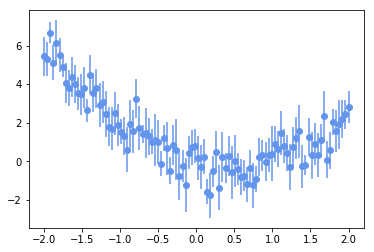

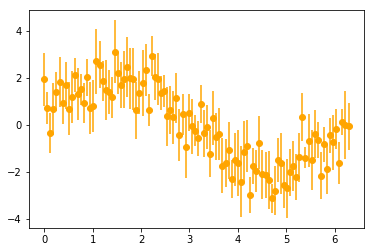

In [2]:
# Make some synthetic data

x1 = np.linspace(-2,2,100)
y1 = x1**2 -x1 + 0.7*np.random.randn(100)
s1 = 1.0 + 0.2*np.random.randn(100)

plt.figure()
plt.errorbar(x1, y1, yerr=s1, fmt='o', color='cornflowerblue')
plt.show()

x2 = np.linspace(0,2*pi,100)
y2 = 2*np.sin(x2) + 0.7*np.random.randn(100)
s2 = 1.0 + 0.2*np.random.randn(100)

plt.figure()
plt.errorbar(x2, y2, yerr=s2, fmt='o', color='orange')
plt.show()

optimizing logp for variables: ['phi_interval__', 'k_log__', 'Amp_log__', 'c', 'b', 'a']
message: Optimization terminated successfully.
logp: -777.5317702583759 -> -239.38796161112975


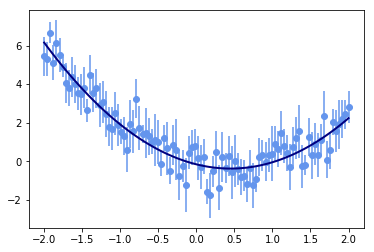

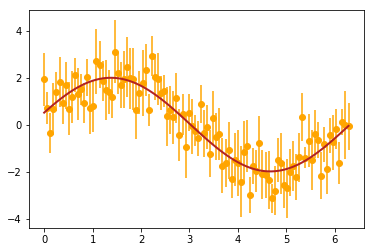

In [4]:
with pm.Model() as model:
    # fit the quadratic function
    a = pm.Normal('a', mu=0, sd=1)
    b = pm.Normal('b', mu=0, sd=1)
    c = pm.Normal('c', mu=0, sd=1)
    
    quadratic = pm.Deterministic('quadratic', a*x1**2 + b*x1 + c)
    
    likelihood = pm.Normal('qlike', mu=quadratic, sd=s1, observed=y1)

    
    # fit the sinusoidal function
    Amp = pm.HalfNormal('Amp', sd=1)
    k   = pm.HalfNormal('k', sd=1)
    phi = pm.Uniform('phi', lower=0, upper=2*pi)
    
    sinusoid = pm.Deterministic('sinusoid', Amp*T.sin(k*x2-phi))
    
    likelihood += pm.Normal('slike', mu=sinusoid, sd=s2, observed=y2)
    

with model:
    map_soln = exo.optimize(start=model.test_point)
    
    
plt.figure()
plt.errorbar(x1, y1, yerr=s1, fmt='o', color='cornflowerblue', zorder=0)
plt.plot(x1, map_soln['quadratic'], color='navy', lw=2)
plt.show()

plt.figure()
plt.errorbar(x2, y2, yerr=s2, fmt='o', color='orange', zorder=0)
plt.plot(x2, map_soln['sinusoid'], color='firebrick', lw=2)
plt.show()